In [1]:
import pandas as pd
from sqlalchemy import create_engine
import json

# DB 접속 정보 로드
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

In [3]:
uv_ray_day = pd.read_sql("SELECT * FROM uv_ray_day", con=engine)

In [4]:
print(uv_ray_day.isnull().sum())

id            0
datetime      0
region        0
uv_max      328
dtype: int64


In [ ]:
uv_ray_day.tail()

,id,datetime,region,uv_max
3830,3831,2025-06-27,서울시,6.3
3831,3832,2025-06-28,서울시,5.4
3832,3833,2025-06-29,서울시,5.4
3833,3834,2025-06-30,서울시,7.3
3834,3835,2025-07-01,서울시,9.5


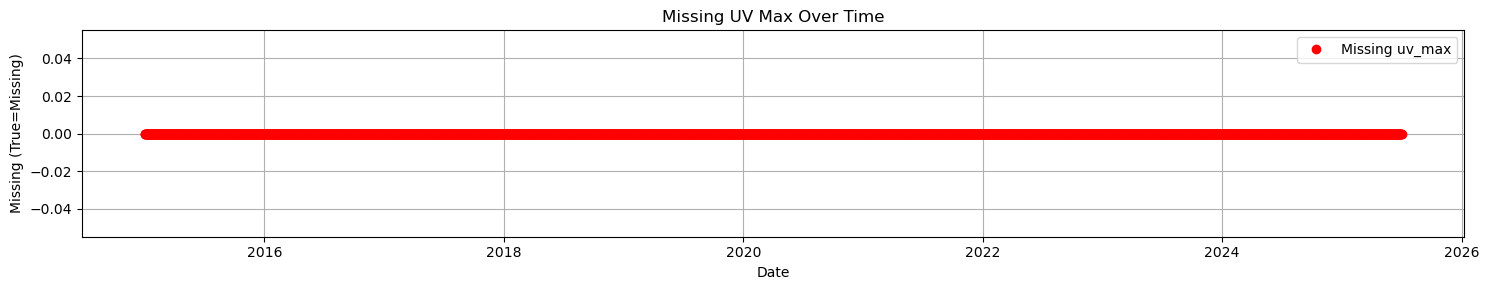

In [9]:
#결측치 시각화

import matplotlib.pyplot as plt

# datetime을 인덱스로 설정 (시계열 시각화를 위해)
uv_ray_day_sorted = uv_ray_day.sort_values('datetime').set_index('datetime')

# 결측 여부를 Boolean으로 변환
is_nan = uv_ray_day_sorted['uv_max'].isna()

# 시각화
plt.figure(figsize=(15, 3))
plt.plot(is_nan.index, is_nan, marker='o', linestyle='', color='red', label='Missing uv_max')
plt.title("Missing UV Max Over Time")
plt.xlabel("Date")
plt.ylabel("Missing (True=Missing)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
#연도별 평균 결측치 fill

import pandas as pd

# datetime을 datetime 타입으로 변환 (안 돼 있다면)
uv_ray_day['datetime'] = pd.to_datetime(uv_ray_day['datetime'])

# 연도 컬럼 생성
uv_ray_day['year'] = uv_ray_day['datetime'].dt.year

# 연도별 평균 uv_max 계산
yearly_avg = uv_ray_day.groupby('year')['uv_max'].mean()

# 결측치를 연도별 평균으로 채우기
def fill_with_yearly_mean(row):
    if pd.isna(row['uv_max']):
        return yearly_avg[row['year']]
    else:
        return row['uv_max']

uv_ray_day['uv_max'] = uv_ray_day.apply(fill_with_yearly_mean, axis=1)

# year 컬럼 제거 (원래대로)
uv_ray_day.drop(columns='year', inplace=True)

In [12]:
print(len(uv_ray_day))

3835


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# 필요한 열만 선택
data = uv_ray_day[['datetime', 'uv_max']].copy()
data.sort_values('datetime', inplace=True)
data.reset_index(drop=True, inplace=True)

# 정규화 준비
scaler = MinMaxScaler()
scaled_uv = scaler.fit_transform(data['uv_max'].values.reshape(-1, 1))

In [14]:
INPUT_LEN = 60   # 과거 60일을 보고
OUTPUT_LEN = 30  # 미래 30일 예측

X, y = [], []

for i in range(len(scaled_uv) - INPUT_LEN - OUTPUT_LEN + 1):
    X.append(scaled_uv[i:i+INPUT_LEN])
    y.append(scaled_uv[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3746, 60, 1)
y shape: (3746, 30, 1)


In [15]:
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:].copy()    # 마지막 시점 기준으로 향후 30일 예측
y_test = y[-1:].copy()    # 실제값 비교용

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (3745, 60, 1) X_test: (1, 60, 1)


In [16]:
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(INPUT_LEN, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(OUTPUT_LEN))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0722 - val_loss: 0.0241
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0155 - val_loss: 0.0234
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0148 - val_loss: 0.0248
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0149 - val_loss: 0.0242
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0143 - val_loss: 0.0233
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0141 - val_loss: 0.0233
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0144 - val_loss: 0.0233
Epoch 8/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0146 - val_loss: 0.0242
Epoch 9/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0144 - val_loss: 0.0232
Epoch 10/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0144 - val_loss: 0.0231
Epoch 11/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0139 - val_loss: 0.0233
Epoch 12/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
lstm_pred = model.predict(X_test)

# 정규화 해제
predicted_uv = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()
actual_uv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


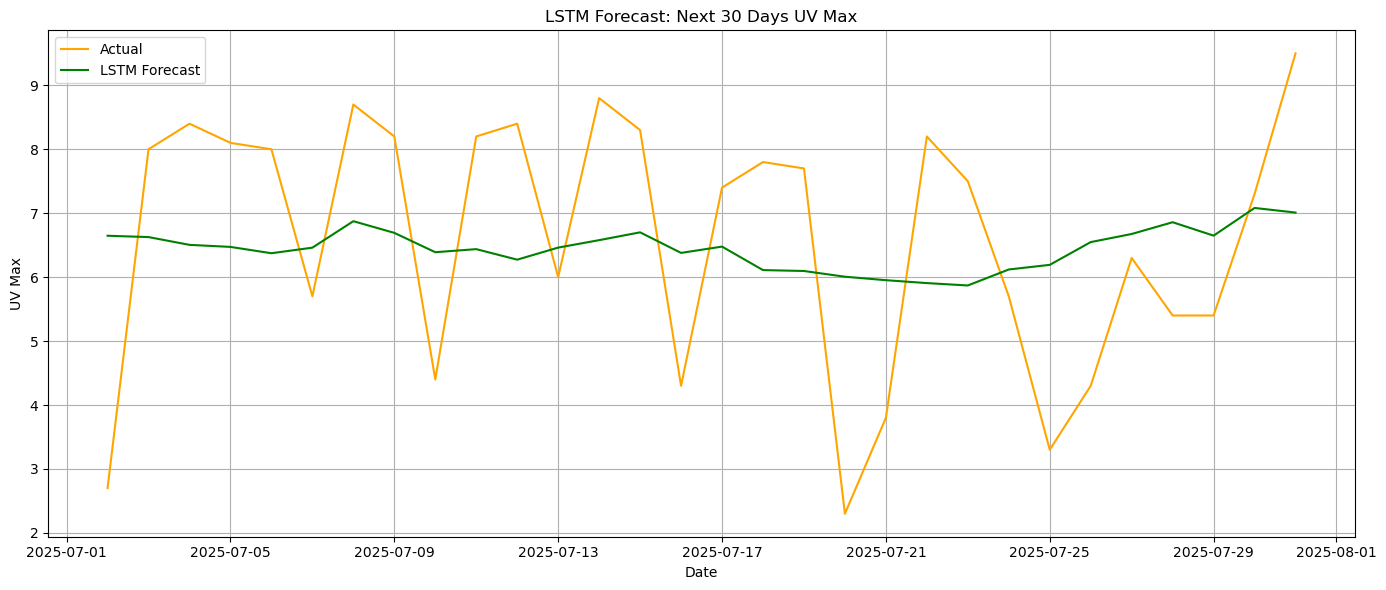

In [18]:
import matplotlib.pyplot as plt

# 날짜 생성
last_date = data['datetime'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# 시각화
plt.figure(figsize=(14,6))
plt.plot(forecast_dates, actual_uv, label='Actual', color='orange')
plt.plot(forecast_dates, predicted_uv, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast: Next 30 Days UV Max')
plt.xlabel('Date')
plt.ylabel('UV Max')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
rmse = sqrt(mean_squared_error(actual_uv, predicted_uv))
print(f"LSTM RMSE (30일 예측): {rmse:.2f}")

LSTM RMSE (30일 예측): 1.94


In [20]:
import pandas as pd

# 날짜 인덱스 생성 (예: 2025년 7월 1일부터 30일)
forecast_dates = pd.date_range(start='2025-07-01', periods=30, freq='D')

# DataFrame으로 비교
df_compare = pd.DataFrame({
    'Date': forecast_dates,
    'Actual (UV)': actual_uv,
    'Predicted (UV)': predicted_uv
})

# 보기 좋게 출력
print(df_compare.head(10))  # 앞 10개만 미리 보기

        Date  Actual (UV)  Predicted (UV)
0 2025-07-01          2.7        6.647246
1 2025-07-02          8.0        6.626485
2 2025-07-03          8.4        6.504832
3 2025-07-04          8.1        6.472776
4 2025-07-05          8.0        6.373843
5 2025-07-06          5.7        6.460947
6 2025-07-07          8.7        6.874917
7 2025-07-08          8.2        6.692343
8 2025-07-09          4.4        6.389794
9 2025-07-10          8.2        6.437829


In [21]:
import pandas as pd

# 예측 결과: future_uv
# 날짜 생성
future_dates = pd.date_range(start='2025-07-01', periods=30, freq='D')

# 데이터프레임 구성
df_pred = pd.DataFrame({
    'id': range(1, 31),  # 1부터 30까지 ID
    'datetime': future_dates,
    'region': ['서울시'] * 30,
    'uv_pred': predicted_uv  # LSTM 예측값
})

In [22]:
df_pred.to_sql('uv_pred_day', 
               con=engine, 
               index=False, 
               if_exists='replace')
# 첫 저장 시에는 replace or fail

30

In [23]:
check = pd.read_sql("SELECT * FROM uv_pred_day", con=engine)
print(check.head())

   id   datetime region  uv_pred
0   1 2025-07-01    서울시  6.64725
1   2 2025-07-02    서울시  6.62648
2   3 2025-07-03    서울시  6.50483
3   4 2025-07-04    서울시  6.47278
4   5 2025-07-05    서울시  6.37384


In [24]:
model.save('uv_lstm_model.h5')

In [27]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('uv_lstm_model.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,968 (78.00 KB)

 Trainable params: 19,966 (77.99 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)